In [1]:
import numpy as np
from sklearn import manifold
from apricot import FacilityLocationSelection
from apricot import FeatureBasedSelection
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import umap
from sklearn.manifold import TSNE
import pandas as pd
import os


In [2]:
def getChrLen ( chr = 'chr1', assembly = 'hg19' ):
    chrsizes = np.loadtxt('/data/locusselect/' + assembly + '.chromsizes.txt',dtype={'names': ('chr','len'),'formats':('S6','i4')} )
    #print (chrsizes)
    for i in range(len(chrsizes)):
        if ( chrsizes[i][0].decode() == chr ):
            return (chrsizes[i][1] )
        
def generateWindows (chrs,res) :
        for chr in chrs:
                chrLen = getChrLen(chr)
                L = int(np.ceil(float(chrLen) / res ))
                starts = np.arange(0,L*res,res)
                ends = np.arange(res,(L+1)*res,res);    ends[-1] = chrLen
                chrNames = np.repeat(np.array([chr]),L)

        table = np.zeros(int(L), dtype={'names':('chr', 'start', 'end'),'formats':('S5', 'i4', 'i4')})
        table['chr'] = chrNames; table['start'] = starts+1; table['end'] = ends;
        return(table)

def averageMatrix(m, startRes=25, endRes=1000) :
        if endRes % startRes != 0 :
                print ("resolutions problematic, find a divisible one")
                return -1
        k = endRes / startRes
        (y,x) = np.shape(m)
        
        sliceSeq = np.arange(0,x,k)
        
        averagedM = np.zeros((y,int(np.ceil( x/float(k)))) )
        
        for i in range(len(sliceSeq)-1) :
                averagedM[:,i] = np.average(m[:,int(sliceSeq[i]):int(sliceSeq[i+1])],axis=1)

        averagedM[:,-1] = np.average(m[:,int(sliceSeq[-1]):x],axis=1)

        return (averagedM)

def chooseResolution (p, resolution='all') :
    if resolution == 'all' :
        p = p
    if resolution == 'high' :
        p = p[:,0:25]
    if resolution == 'mid' :
        p = p[:,25:65]
    if resolution == 'highmid' :
        p = p[:,0:65]
    if resolution == 'low' :
        p = p[:,65:110]
    return p
    
def umap_transform(peak_data, n_components=3, random_state=25, metric = 'correlation',n_neighbors=15,min_dist=0.1):
    umap_obj = umap.UMAP(n_components=n_components, random_state=random_state,
        min_dist=min_dist,metric=metric,n_neighbors=n_neighbors)
    try:
        umap_res = umap_obj.fit_transform(peak_data.toarray())
    except:
        umap_res = umap_obj.fit_transform(peak_data)
    return umap_res
    
def intersectBeds ( bed1, bed2, pickLargestOverlap = True ) :
    chrs1 = np.unique(bed1['f0']);  chrs2 = np.unique(bed2['f0'])
    allchrs = np.intersect1d(chrs1,chrs2)
    overlapInd1 = []; overlapInd2 = []; overlapLen = []
    for chr in allchrs :
        Ind1 = np.where(bed1['f0']==chr)[0];    Ind2 = np.where(bed2['f0']==chr)[0]
        midPoint1 = ( bed1['f2'][Ind1] + bed1['f1'][Ind1] ) / 2
        midPoint2 = ( bed2['f2'][Ind2] + bed2['f1'][Ind2] ) / 2
        int1 = bed1['f2'][Ind1] - bed1['f1'][Ind1] + 1
        int2 = bed2['f2'][Ind2] - bed2['f1'][Ind2] + 1
        maxInt = 2 * np.max(np.append(int1,int2))
        for I in range(len(Ind1)) :
            dist = np.abs( midPoint1[I] - midPoint2 )
            closeInd = Ind2[ np.where( dist < maxInt )[0] ]
            if len(closeInd) > 0 :
                for I2 in closeInd :
                    maxStart = max(bed1[Ind1[I]][1], bed2[I2][1])
                    minEnd = min(bed1[Ind1[I]][2], bed2[I2][2])
                    if maxStart < minEnd:
                        overlapInd1.append(Ind1[I])
                        overlapInd2.append(I2)
                        overlapLen.append(minEnd-maxStart)
                        
    overlapInd1 = np.array(overlapInd1); overlapInd2 = np.array(overlapInd2); overlapLen = np.array(overlapLen)
    
    uniqueOverlapInd1 = []; uniqueOverlapInd2 = []; uniqueOverlapLen = []
    if pickLargestOverlap == True :
        uniqueOI1 = np.unique(overlapInd1)
        for uI in uniqueOI1 :
            Ind = np.where(overlapInd1==uI)[0]
            Ord = np.argsort(overlapLen[Ind])
            uniqueOverlapInd1.append(uI); uniqueOverlapInd2.append(overlapInd2[Ind[Ord[-1]]]);
            uniqueOverlapLen.append(overlapLen[Ind[Ord[-1]]])
    
    uniqueOverlapInd1 = np.array(uniqueOverlapInd1); uniqueOverlapInd2 = np.array(uniqueOverlapInd2)
    uniqueOverlapLen = np.array(uniqueOverlapLen)
    
    return (uniqueOverlapInd1,uniqueOverlapInd2,uniqueOverlapLen)

def plot_embedding_3d(embedding, num_labels, label_dict, cmap=None):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection='3d')
    labels = np.unique(num_labels)
    scatter_res = ax.scatter(embedding[:,0], embedding[:,1], embedding[:,2],
     s=4, alpha=1,c=num_labels, cmap='jet')

    legend_proxies = []; legend_labels = []
    for label in label_dict.keys() :
        legend_color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
        legend_proxies.append(matplotlib.lines.Line2D([0], [0], linestyle='none', c=legend_color, marker='o'))
        legend_labels.append(label)
    ax.legend(legend_proxies, legend_labels, numpoints=1, loc='upper left')#bbox_to_anchor=(1, 1))

def plot_embedding_2d(embedding, num_labels=None, label_dict=None, s_dict=None, a_dict=None, cmap=None, norm=None, title='' ):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111)
    if num_labels is None or label_dict is None :
        scatter_res = ax.scatter(embedding[:,0], embedding[:,1], s=4, alpha=1)

    else :
        for label in label_dict.keys() :
            Ind = np.where(num_labels == label_dict[label])[0]
            color = cm.jet(label_dict[label] / float(len(label_dict.keys()) - 1))
            if s_dict is None : 
                dotsize = 4 
            else : 
                dotsize = s_dict[label]
            if a_dict is None : 
                alpha = 1
            else : 
                alpha = a_dict[label]
            scatter_res = ax.scatter(embedding[Ind,0], embedding[Ind,1], s=dotsize, alpha=alpha,c=color, label=label)
        ax.set_xlim( min(embedding[:,0]) - ( ( max(embedding[:,0]) - min(embedding[:,0]) ) * 0.5 ), max(embedding[:,0]) )
        ax.set_ylim( min(embedding[:,1]), max(embedding[:,1]) + ( ( max(embedding[:,1]) - min(embedding[:,1]) ) * 0.5 ) )
        ax.set_title(title)
        ax.legend(loc='upper left',prop={'size': 12})
          
def plotBox ( data, ax = None, arcsinhFlag = True, outliers = False, title = None ) :
    if arcsinhFlag : 
        plotData = [ np.arcsinh( data[:,i] ) for i in range(np.shape(data)[1]) ]    
    else :
        plotData = [ data[:,i] for i in range(np.shape(data)[1]) ]    
    if ax is None :
        plt.boxplot( plotData, showfliers = outliers )
        if title is not None :
            plt.title(title)
        plt.show()
    if ax is not None :
        ax.boxplot( plotData, showfliers = outliers )
        if title is not None :
            ax.set_title(title)

def parseAvocadoLocus ( chr, start, end, resolution = 'highmid', process = None, process_res = None, datapath = '/net/noble/vol2/home/gurkan/proj/2018locus_selection/Data/nn_avocado/raw/' ) :
    data = np.load(datapath+'genome_'+chr+'.npy')
    data_res = chooseResolution(data,resolution)

    #GET THE FACTORS at LOCUS OF INTEREST (MYC)
    startI = int(start / 25); endI = int(end / 25); 
    data_locus = data_res[np.arange(startI,endI),:]
    
    if process is not None and process_res is not None and process is 'average' :
        data_locus = np.transpose(averageMatrix(np.transpose(data_locus),25,process_res))
    if process is not None and process_res is not None and process is 'min' :
        data_locus = np.transpose(minMatrix(np.transpose(data_locus),25,process_res))
    return(data_locus)

def generateLocusWindows ( chr, start, end, resolution ) :
    windows = generateWindows([chr],resolution)
    startI = int(start / resolution); endI = int(end / resolution); 
    locus_windows = windows[np.arange(startI,endI)]
    locus_windows.dtype.names = ['f0','f1','f2']
    return (locus_windows)

def makeHistoneChIPMatrix (data, arcsinhFlag = True) :
    if arcsinhFlag : 
        data_list = [ np.arcsinh( data[fieldname] ) for fieldname in data.dtype.names[1:]]    
    else :
        data_list = [ data[fieldname] for fieldname in data.dtype.names[1:]]
    data_matrix = np.transpose(np.vstack(data_list))
    return(data_matrix)

def makeBed ( labels ) :
    chrNames = np.array ([ (coords.decode()).split('_')[0] for coords in labels ] )
    starts = np.array ([ int((coords.decode()).split('_')[1]) for coords in labels ] )
    ends = np.array ([ int((coords.decode()).split('_')[2]) for coords in labels ] )
    
    table = np.zeros(len(chrNames), dtype={'names':('f0', 'f1', 'f2'),'formats':('S5', 'i4', 'i4')})
    table['f0'] = chrNames; table['f1'] = starts+1; table['f2'] = ends;
    return(table)
    
def selectSubset ( data_matrix, n = None, distance = 'euclidean', initial_subset = None, selection_subset = None ) :
    if selection_subset is not None :
        data_matrix = data_matrix[selection_subset]
    
    if n is None :
        n = np.shape(data_matrix)[0]
    
    if initial_subset is None :
        model = FacilityLocationSelection(n, distance)
    else :
        model = FacilityLocationSelection(n, distance, initial_subset = initial_subset )
    
    Xi = model.fit_transform(data_matrix)
    SubsetInd = model.ranking
    Gains = model.gains
    
    if selection_subset is not None :
        SubsetInd = selection_subset[SubsetInd]
    
    return SubsetInd, Gains

def makeSegwayAnnotation ( loci_windows, segway_anno) :
    I1,I2,L1 = intersectBeds(loci_windows,segway_anno)

    if len(I1) == len(loci_windows) : 
        segway_labels = segway_anno['f3'][I2]
    else :
        segway_labels = np.repeat('0_Undetermined',len(loci_windows))
        segway_labels[I1] = segway_anno['f3'][I2]

    segway_labels = [ label.split('_')[1] for label in segway_labels ]
    segway_labels = np.array(segway_labels)
    unique_labels = np.unique(segway_labels)
    label_dict = {}
    for i in range(len(unique_labels)) :
        label_dict[unique_labels[i]] = i+1
    segway_num_labels = [ label_dict[label] for label in segway_labels ]
    
    return (segway_num_labels, label_dict)


def makeccREAnnotation ( loci_windows, ccREs ) :
    I1,I2,L1 = intersectBeds(loci_windows,ccREs)

    ccRE_num_labels = np.zeros(len(loci_windows))
    ccRE_num_labels[I1] = 1
    
    label_dict = { 'ccRE' : 1, 'All' : 0 }
    return (ccRE_num_labels, label_dict)

def makeSubsetAnnotation ( subsetInd, subsetSize = None, k = 100 ) :
    if subsetSize is None :
        subsetSize = len(subsetInd)
    subset_num_labels = np.zeros(subsetSize)
    subset_num_labels[subsetInd[0:k]] = 1
    
    label_dict = { 'Subset' : 1, 'All' : 0 }
    return (subset_num_labels, label_dict)

def makeGeneralAnnotation ( Ind_list, label_list, k ) :
    num_labels = np.zeros(k)
    
    label_dict = { 'All' : 0 }
    for i in range(len(Ind_list)) :
        num_labels[Ind_list[i]] = i + 1
        label_dict[label_list[i]] = i + 1
    return (num_labels, label_dict)

In [3]:
def performEmbeddings ( data_list, n_components=2, random_state=2, metric= 'correlation', n_neighbors=15 ) :
    embedding_list = []; 
    for data in data_list :
        embedding_list.append( umap_transform(data, n_components=2, random_state=2, 
                                              n_neighbors=n_neighbors, metric=distanceMeasure)
                             )
    return (embedding_list)

In [4]:
lociList = [ [ 'BCL11A', 'chr2', 59780500, 61780750 ], 
#['GATA1', 'chrX', 47644750, 49645000 ],
['HBA2', 'chr16', 60000, 1223000 ],
['HBE1', 'chr11', 4526750, 6527000 ],
['LMO2', 'chr11', 32891250, 34891500 ],
['MYC', 'chr8', 127748250, 129748500 ],
['RBM38', 'chr20', 54966250, 56966500 ] ]

avocado_gene_names = [ 'BCL11A',  'HBA2', 'HBE1', 'LMO2', 'MYC', 'RBM38' ]

In [5]:
datapath='/data/locusselect/k562_histone_marks/'
histone_data = np.genfromtxt(datapath+'K562.binsize_250.mean.in_loci_of_interest.txt',dtype=None,skip_header=1)
markNames = [ 'H2AFZ-human','H3K27ac-human','H3K27me3-human','H3K36me3-human','H3K4me1-human','H3K4me2-human',
             'H3K4me3-human','H3K79me2-human' ,'H3K9ac-human','H3K9me3-human' ]

locus_names = np.array ([ (coords.decode()).split('_')[-1] for coords in histone_data['f0'] ] )
histone_gene_names, loci_counts = np.unique(locus_names,return_counts=True)
bed = makeBed (histone_data['f0'])
#DROP GATA
histone_gene_names = histone_gene_names[[0,2,3,4,5,6]]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  


In [6]:
histone_data_list = []; histone_rawdata_list = []; histone_bed_list = []
for gene_name in histone_gene_names :
    Ind = np.where(locus_names==gene_name)[0]
    thisMatrix = makeHistoneChIPMatrix(histone_data[Ind],False);
    
    #FILTER OUT WINDOWS WITH NON-UNIQUE SCORES
    rs = np.sum(thisMatrix,1); urs, urscount = np.unique(rs,return_counts=True)
    filterInd = np.array([])
    for thisurs in urs[urscount > 1]:
        filterInd = np.append(filterInd,np.where(rs==thisurs)[0])
    filterInd = Ind[filterInd.astype(int)]
    Ind = np.setdiff1d(Ind,filterInd)
    
    histone_data_list.append(makeHistoneChIPMatrix(histone_data[Ind],True))
    histone_rawdata_list.append(makeHistoneChIPMatrix(histone_data[Ind],False))
    histone_bed_list.append(bed[Ind])

In [7]:
distanceMeasure = 'correlation'
histone_embedding_list = performEmbeddings(histone_data_list,metric=distanceMeasure); 

In [8]:
histone_data_list[0].shape, histone_rawdata_list[0].shape, histone_bed_list[0].shape

((7534, 10), (7534, 10), (7534,))

In [9]:
groseq = "/data/locusselect/k562_annotations/hg19.k562.pair.div.bed"
gropeaks = pd.read_csv("positive_gropeak.bed", sep='\t', header=None)


In [10]:
def get_labels(bed_list):
    labels_list = []
    count = 0
    total = 0
    overlap_list = []
    for coordlist in bed_list:
        labels = []
        overlaps = []
        for coord in coordlist:
            bin0 = (coord[0].decode("utf8"), int(coord[1]), int(coord[2]))
            olstart = gropeaks[(gropeaks[0]==bin0[0]) & (bin0[1]>gropeaks[1]) & (bin0[1]<gropeaks[2])] #start is not inside
            olend = gropeaks[(gropeaks[0]==bin0[0]) & (bin0[2]>gropeaks[1]) & (bin0[2]<gropeaks[2])] #end in not inside
            if(olstart.shape[0]==0 and olend.shape[0]==0):
                overlap = 0
            elif(olstart.shape[0]==0 and olend.shape[0]!=0):
                #print("only end is inside")
                overlap = max(bin0[2] - olend.loc[:,1].values)/250.0
            elif(olstart.shape[0]!=0 and olend.shape[0]==0):
                #print("only start is inside")
                overlap = max(olstart.loc[:,2].values - bin0[1]+1)/250.0 
            elif(olstart.shape[0]!=0 and olend.shape[0]!=0):
                overlap = 1.0
            if(overlap>0.1):
                label=1
                count = count+1
            else:
                label=0
            total = total+1
            labels.append(label)
            overlaps.append(overlap)
        labels_list.append(labels)
        overlap_list.append(overlaps)
            #bin0 = pybedtools.create_interval_from_list([coord[0].decode("utf8"), int(coord[1]), int(coord[2])])
    print(count, total)
    return labels_list, overlap_list
labels_list, overlap_list = get_labels(histone_bed_list)

243 42776


In [12]:
def split_data(data_list, labels_list):
    train_data_list = []
    test_data_list = []
    train_labels_list = []
    test_labels_list = []
    imbalance_in_train = []
    imbalance_in_test = []
    for i in range(len(data_list)):
        #print(i)
        data = data_list[i]
        labels = np.expand_dims(np.array(labels_list[i]), axis=1)
        
        train_size = int(data.shape[0]*0.7)
        train_data = data[:train_size]
        test_data = data[train_size:]
        train_data_list.append(train_data)
        test_data_list.append(test_data)
        
        train_labels = labels[:train_size]
        test_labels = labels[train_size:]
        train_labels_list.append(train_labels)
        test_labels_list.append(test_labels)
        
        npos = np.sum(np.array(train_labels)>0)
        nneg = len(train_labels) - npos
        imbalance_in_train.append(1.0*npos/(npos+nneg))
        
        npos = np.sum(np.array(test_labels)>0)
        nneg = len(test_labels) - npos
        imbalance_in_test.append(1.0*npos/(npos+nneg))

    splited_data = {'train': train_data_list, 'test': test_data_list}
    splited_labels = {'train': train_labels_list, 'test': test_labels_list}
    splited_imbalances = {'train': imbalance_in_train, 'test': imbalance_in_test}
    return splited_data, splited_labels, splited_imbalances

histone_splited_list, splited_labels, splited_imbalance = split_data(histone_data_list, labels_list)
raw_splited_list, raw_splited_labels, raw_splited_imbalance = split_data(histone_rawdata_list, labels_list)
embedded_splited_list, embedded_labels, embedded_imbalance = split_data(histone_embedding_list, labels_list)
#raw_splited_list, raw_splited_labels, raw_splited_imbalance = split_data(raw_data_list, labels_list)

In [17]:
histone_SSIndex_list = []
for data in histone_splited_list['train'] :
    N = np.shape(data)[0]
    SubsetInds,gains = selectSubset( data, n = N, distance = 'corr' )
    histone_SSIndex_list.append(SubsetInds)

In [24]:
def merge_data_labels(data_list, labels_list):
    
    total_data = None
    
    for i in range(len(data_list)):
        x = data_list[i]
        y = labels_list[i]
        
        data = np.hstack((y,x))
        if(total_data is None):
            total_data = data
        else:
            total_data = np.vstack((total_data, data))

    print(total_data.shape)
    
    return total_data

histone_test_data = merge_data_labels(histone_splited_list['test'], splited_labels['test'])
histone_train_data = merge_data_labels(histone_splited_list['train'], splited_labels['train'])

##
#rawhistone_test_data = merge_data_labels(histone_rawdata_list['test'], splited_labels['test'])
#rawhistone_train_data = merge_data_labels(histone_rawdata_list['train'], splited_labels['train'])
#embeddedhistone_test_data = merge_data_labels(histone_embedding_list['test'], splited_labels['test'])
#embeddedhistone_train_data = merge_data_labels(histone_embedding_list['train'], splited_labels['train'])

(12836, 11)
(29940, 11)


In [74]:

def sample_merge_data_labels(data_list, labels_list, histone_SSIndex_list=None, ss_size=None):
    total_data = None
    for i in range(len(data_list)):
        #print(i)
        x = data_list[i]
        y = labels_list[i]
        if(ss_size is not None):
            if(histone_SSIndex_list is None):
                SSIndex = np.random.choice(x.shape[0], ss_size)
            else:
                SSIndex = histone_SSIndex_list[i]
            x = x[SSIndex[0:ss_size]]
            y = y[SSIndex[0:ss_size]]
        
        data = np.hstack((y, x))
        if(total_data is None):
            total_data = data
        else:
            total_data = np.vstack((total_data, data))


    print(total_data.shape)
    
    return total_data


ss_sizes = range(1000, 2001, 100)
histone_train_data_selected_list = []
histone_train_data_random_list = []
for ss_size in ss_sizes:
    #print(ss_size)
    histone_train_data_selected_list.append(sample_merge_data_labels(histone_splited_list['train'], 
                                                           splited_labels['train'],
                                                 histone_SSIndex_list, ss_size=ss_size))
    histone_train_data_random_list.append(sample_merge_data_labels(histone_splited_list['train'], 
                                                           splited_labels['train'],
                                                 None, ss_size=ss_size))
    
# histone_train_data_1k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1000)
# histone_train_data_1_3k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1300)
# histone_train_data_1_5k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1500)

# histone_train_data_1_6k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1600)
# histone_train_data_1_7k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1700)
# histone_train_data_1_8k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1800)
# histone_train_data_1_9k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=1900)

# histone_train_data_2k = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 histone_SSIndex_list, ss_size=2000)

# histone_train_data_1k_rand = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 None, ss_size=1000)
# histone_train_data_1_5k_rand = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 None, ss_size=1500)
# histone_train_data_2k_rand = sample_merge_data_labels(histone_splited_list['train'], splited_labels['train'],
#                                                 None, ss_size=2000)


(6000, 11)
(6000, 11)
(6600, 11)
(6600, 11)
(7200, 11)
(7200, 11)
(7800, 11)
(7800, 11)
(8400, 11)
(8400, 11)
(9000, 11)
(9000, 11)
(9600, 11)
(9600, 11)
(10200, 11)
(10200, 11)
(10800, 11)
(10800, 11)
(11400, 11)
(11400, 11)
(12000, 11)
(12000, 11)


In [75]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve, auc
def make_prediction(train_data, test_data, header="", plot=True):
    
    model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')#.fit(X, y)
    model.fit(train_data[:, 1:], train_data[:, 0]) #1st column is label
    predicted_classes = model.predict(test_data[:, 1:]) #1st column is label
    
    average_precision = average_precision_score(test_data[:, 0], predicted_classes)
    precision, recall, _ = precision_recall_curve(test_data[:, 0], predicted_classes)
    area = auc(recall, precision)
    if(plot):
        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        # step_kwargs = ({'step': 'post'}
        #                if 'step' in signature(plt.fill_between).parameters
        #                else {})
        plt.fill_between(recall, precision, alpha=0.2, color='b')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('{0}\nArea Under Precision-Recall curve: {1}'.format(header, round(area, 2)))
    return area

In [76]:
accumulated_auprcs_selected = []
accumulated_auprcs_random = []
accumulated_sizes = []
for i in range(len(ss_sizes)):
    histone_train_data_selected = histone_train_data_selected_list[i]
    histone_train_data_random = histone_train_data_random_list[i]
    
    area_selected = make_prediction(histone_train_data_selected, histone_test_data, "", False)
    accumulated_auprcs_selected.append(area_selected); 
    
    area_random = make_prediction(histone_train_data_random, histone_test_data, "", False)
    accumulated_auprcs_random.append(area_random); 
    
    data_size = histone_train_data_selected.shape[0]
    accumulated_sizes.append(data_size)

Text(0, 0.5, 'auPRC')

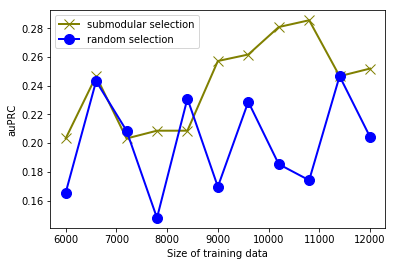

In [84]:
import matplotlib.pyplot as plt
import pandas as pd
df=pd.DataFrame({'selected': accumulated_auprcs_selected, 'random': accumulated_auprcs_random, 
                 'data_size': accumulated_sizes })

plt.plot( 'data_size', 'selected', data=df, markersize=10, linewidth=2, 
         marker='x', color='olive', label="submodular selection")
plt.plot( 'data_size', 'random', data=df, markersize=10, linewidth=2, 
         marker='o',  color='blue', label="random selection")
plt.legend()
plt.xlabel("Size of training data")
plt.ylabel("auPRC")
#plt.title("Checking Optimal number of examples for training")

0.21457216046652008

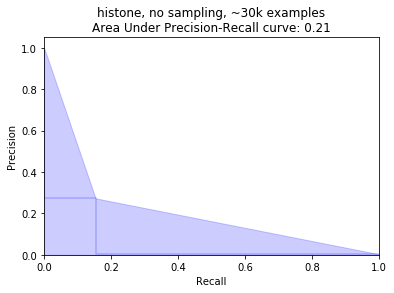

In [39]:

make_prediction(histone_train_data, histone_test_data, "histone, no sampling, ~30k examples")

0.20320852410288373

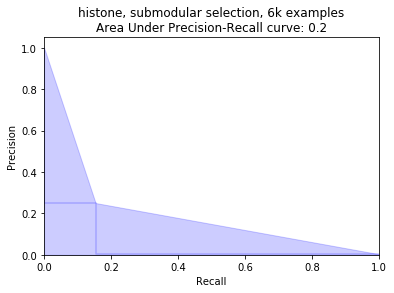

In [40]:
area = make_prediction(histone_train_data_1k, histone_test_data, "histone, submodular selection, 6k examples")

0.2571782037298943

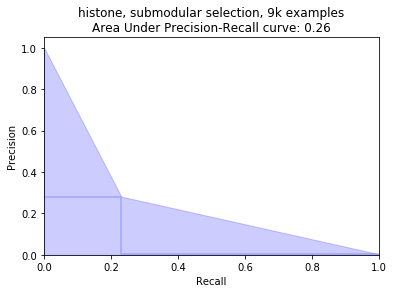

In [41]:
area = make_prediction(histone_train_data_1_5k, histone_test_data, "histone, submodular selection, 9k examples")

0.25191979200237224

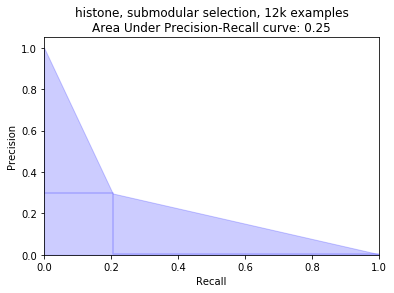

In [58]:
area = make_prediction(histone_train_data_2k, histone_test_data, "histone, submodular selection, 12k examples")

0.18165679996495268

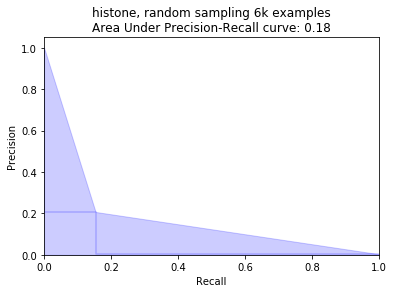

In [43]:
area = make_prediction(histone_train_data_1k_rand, histone_test_data, "histone, random sampling 6k examples")

0.13264540435154332

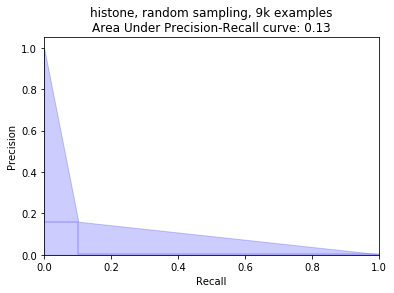

In [44]:
area = make_prediction(histone_train_data_1_5k_rand, histone_test_data, "histone, random sampling, 9k examples")

0.17412261640112656

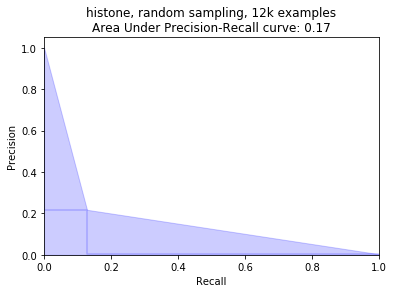

In [45]:
area = make_prediction(histone_train_data_2k_rand, histone_test_data, "histone, random sampling, 12k examples")